In [1]:
import pandas
import konlpy
import gensim
import tensorflow as tf

print(pandas.__version__)
print(konlpy.__version__)
print(gensim.__version__)

1.3.3
0.5.2
4.1.2


In [2]:
import pandas as pd

train_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_train.txt')
test_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_test.txt')

train_data.tail()

,id,document,label
149995,6222902,인간이 문제지.. 소는 뭔죄인가..,0
149996,8549745,평점이 너무 낮아서...,1
149997,9311800,이게 뭐요? 한국인은 거들먹거리고 필리핀 혼혈은 착하다?,0
149998,2376369,청춘 영화의 최고봉.방황과 우울했던 날들의 자화상,1
149999,9619869,한국 영화 최초로 수간하는 내용이 담긴 영화,0


데이터로더 구성

In [3]:
from konlpy.tag import Mecab
import numpy as np
from collections import Counter

tokenizer = Mecab()
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

def load_data(train_data, test_data, num_words=10000):
    train_data.drop_duplicates(subset=['document'], inplace=True)
    train_data = train_data.dropna(how = 'any') 
    test_data.drop_duplicates(subset=['document'], inplace=True)
    test_data = test_data.dropna(how = 'any') 
    
    X_train = []
    for sentence in train_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_train.append(temp_X)

    X_test = []
    for sentence in test_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_test.append(temp_X)
    
    words = np.concatenate(X_train).tolist()
    counter = Counter(words)
    counter = counter.most_common(10000-4)
    vocab = ['', '', '', ''] + [key for key, _ in counter]
    word_to_index = {word:index for index, word in enumerate(vocab)}
        
    def wordlist_to_indexlist(wordlist):
        return [word_to_index[word] if word in word_to_index else word_to_index[''] for word in wordlist]
        
    X_train = list(map(wordlist_to_indexlist, X_train))
    X_test = list(map(wordlist_to_indexlist, X_test))
        
    return X_train, np.array(list(train_data['label'])), X_test, np.array(list(test_data['label'])), word_to_index
    
X_train, y_train, X_test, y_test, word_to_index = load_data(train_data, test_data) 

In [4]:
word_to_index = {k:(v+3) for k,v in word_to_index.items()}

word_to_index["<PAD>"] = 0
word_to_index["<BOS>"] = 1
word_to_index["<UNK>"] = 2  
word_to_index["<UNUSED>"] = 3

index_to_word = {index:word for word, index in word_to_index.items()}

In [5]:
def get_encoded_sentence(sentence, word_to_index):
    return [word_to_index['<BOS>']]+[word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in sentence.split()]

def get_encoded_sentences(sentences, word_to_index):
    return [get_encoded_sentence(sentence, word_to_index) for sentence in sentences]

def get_decoded_sentence(encoded_sentence, index_to_word):
    return ' '.join(index_to_word[index] if index in index_to_word else '<UNK>' for index in encoded_sentence[1:])  #[1:]를 통해 <BOS>를 제외

def get_decoded_sentences(encoded_sentences, index_to_word):
    return [get_decoded_sentence(encoded_sentence, index_to_word) for encoded_sentence in encoded_sentences]

In [6]:
word_to_index

{'': 6,
 '.': 7,
 '영화': 8,
 '다': 9,
 '고': 10,
 '하': 11,
 '을': 12,
 '보': 13,
 '..': 14,
 '게': 15,
 ',': 16,
 '!': 17,
 '지': 18,
 '있': 19,
 '없': 20,
 '?': 21,
 '좋': 22,
 '나': 23,
 '었': 24,
 '만': 25,
 '는데': 26,
 '너무': 27,
 '봤': 28,
 '적': 29,
 '안': 30,
 '정말': 31,
 '로': 32,
 '음': 33,
 '것': 34,
 '아': 35,
 '네요': 36,
 '재밌': 37,
 '어': 38,
 '같': 39,
 '점': 40,
 '지만': 41,
 '진짜': 42,
 '했': 43,
 '에서': 44,
 '기': 45,
 '네': 46,
 '않': 47,
 '거': 48,
 '았': 49,
 '수': 50,
 '되': 51,
 '면': 52,
 'ㅋㅋ': 53,
 '말': 54,
 '연기': 55,
 '인': 56,
 '주': 57,
 '내': 58,
 '최고': 59,
 '~': 60,
 '평점': 61,
 '이런': 62,
 '던': 63,
 '어요': 64,
 '할': 65,
 '왜': 66,
 '겠': 67,
 '1': 68,
 '스토리': 69,
 '해': 70,
 '습니다': 71,
 'ㅋㅋㅋ': 72,
 '...': 73,
 '드라마': 74,
 '생각': 75,
 '아니': 76,
 '더': 77,
 '그': 78,
 '싶': 79,
 '사람': 80,
 '듯': 81,
 '때': 82,
 '감동': 83,
 '함': 84,
 '배우': 85,
 '본': 86,
 '까지': 87,
 '뭐': 88,
 '알': 89,
 '만들': 90,
 '내용': 91,
 '볼': 92,
 '감독': 93,
 '보다': 94,
 '라': 95,
 '그냥': 96,
 '재미': 97,
 '시간': 98,
 '지루': 99,
 '중': 100,
 '재미있': 101,
 

In [7]:
#<BOS>값을 1로 초기화
for idx in enumerate(X_train):
    word_to_index['<BOS>'] =1

모델 구성을 위한 데이터 분석 및 가공

In [8]:
vocab_size = len(word_to_index)  
word_vector_dim = 4

embedding = tf.keras.layers.Embedding(input_dim=vocab_size, output_dim=word_vector_dim, mask_zero=True)

raw_inputs = tf.keras.preprocessing.sequence.pad_sequences(X_train,
                                                       value=word_to_index['<PAD>'],
                                                       padding='pre',
                                                       maxlen=5)
output = embedding(raw_inputs)
print(output)

tf.Tensor(
[[[-0.00294102  0.04182435  0.03236571  0.03890386]
  [-0.01534462  0.00504682  0.00444648 -0.02612029]
  [ 0.04470945  0.02693108  0.01259637  0.02516115]
  [-0.04793427 -0.00194093 -0.04208512  0.02252844]
  [ 0.03023395 -0.0147681   0.0048524   0.00166969]]

 [[-0.04538039 -0.03969643  0.02671972  0.04480488]
  [-0.0067845  -0.00469194 -0.02801288 -0.04335186]
  [ 0.02650059 -0.00729424  0.04800821  0.03955834]
  [-0.02329297 -0.04923042  0.04601207 -0.04098483]
  [-0.00054447  0.03921621 -0.04613993 -0.03572755]]

 [[ 0.02710023 -0.04438684  0.04503309 -0.04696133]
  [ 0.02710023 -0.04438684  0.04503309 -0.04696133]
  [ 0.03482557  0.0233652  -0.02577815 -0.04506624]
  [ 0.04148704  0.02428422  0.02956698 -0.00296624]
  [-0.00084627  0.03429371  0.01778135  0.00191516]]

 ...

 [[-0.00084627  0.03429371  0.01778135  0.00191516]
  [-0.00084627  0.03429371  0.01778135  0.00191516]
  [-0.03237076  0.00198265  0.04735439  0.04834834]
  [ 0.03498857 -0.02926807  0.01398237  0

모델 구성 및 validation set 구성

In [9]:
vocab_size = 10 
word_vector_dim = 4 

model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(tf.keras.layers.Conv1D(16, 7, activation='relu'))
model.add(tf.keras.layers.MaxPooling1D(5))
model.add(tf.keras.layers.Conv1D(16, 7, activation='relu'))
model.add(tf.keras.layers.GlobalMaxPooling1D())
model.add(tf.keras.layers.Dense(8, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 4)           40        
_________________________________________________________________
conv1d (Conv1D)              (None, None, 16)          464       
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, None, 16)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, None, 16)          1808      
_________________________________________________________________
global_max_pooling1d (Global (None, 16)                0         
_________________________________________________________________
dense (Dense)                (None, 8)                 136       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9

In [10]:
vocab_size = 10 
word_vector_dim = 4   

model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(tf.keras.layers.GlobalMaxPooling1D())
model.add(tf.keras.layers.Dense(8, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid')) 

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 4)           40        
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 4)                 0         
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 40        
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 9         
Total params: 89
Trainable params: 89
Non-trainable params: 0
_________________________________________________________________


In [11]:
total_data_text = list(X_train) + list(X_test)

num_tokens = [len(tokens) for tokens in total_data_text]
num_tokens = np.array(num_tokens)

print('문장길이 평균 : ', np.mean(num_tokens))
print('문장길이 최대 : ', np.max(num_tokens))
print('문장길이 표준편차 : ', np.std(num_tokens))

max_tokens = np.mean(num_tokens) + 2 * np.std(num_tokens)
maxlen = int(max_tokens)
print('pad_sequences maxlen : ', maxlen)
print('전체 문장의 {}%가 maxlen 설정값 이내에 포함됩니다. '.format(np.sum(num_tokens < max_tokens) / len(num_tokens)))

문장길이 평균 :  15.96940191154864
문장길이 최대 :  116
문장길이 표준편차 :  12.843571191092
pad_sequences maxlen :  41
전체 문장의 0.9342988343341575%가 maxlen 설정값 이내에 포함됩니다. 


In [12]:
X_train = tf.keras.preprocessing.sequence.pad_sequences(X_train,
                                                        value=word_to_index["<PAD>"],
                                                        padding='pre', # 혹은 'pre'
                                                        maxlen=maxlen)

X_test = tf.keras.preprocessing.sequence.pad_sequences(X_test,
                                                       value=word_to_index["<PAD>"],
                                                       padding='pre', # 혹은 'pre'
                                                       maxlen=maxlen)

print(X_train.shape)

(146182, 41)


In [13]:
vocab_size = 10000   
word_vector_dim = 16 

model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(tf.keras.layers.Conv1D(16, 7, activation='relu'))
model.add(tf.keras.layers.MaxPooling1D(5))
model.add(tf.keras.layers.Conv1D(16, 7, activation='relu'))
model.add(tf.keras.layers.GlobalMaxPooling1D())
model.add(tf.keras.layers.Dense(8, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, None, 16)          160000    
_________________________________________________________________
conv1d_2 (Conv1D)            (None, None, 16)          1808      
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, None, 16)          0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, None, 16)          1808      
_________________________________________________________________
global_max_pooling1d_2 (Glob (None, 16)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_5 (Dense)              (None, 1)                

In [14]:
x_val = X_train[:10000]   
y_val = y_train[:10000]

partial_x_train = X_train[10000:]  
partial_y_train = y_train[10000:]

print(partial_x_train.shape)
print(partial_y_train.shape)

(136182, 41)
(136182,)


모델 훈련 개시

In [15]:
import tensorflow as tf
from tensorflow.keras.optimizers import RMSprop

opt = RMSprop(learning_rate=0.0001)
model.compile(opt,
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=20 

history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/20
266/266 [==============================] - 5s 6ms/step - loss: 0.6918 - accuracy: 0.5212 - val_loss: 0.6893 - val_accuracy: 0.5611
Epoch 2/20
266/266 [==============================] - 1s 5ms/step - loss: 0.6802 - accuracy: 0.6181 - val_loss: 0.6661 - val_accuracy: 0.6664
Epoch 3/20
266/266 [==============================] - 1s 5ms/step - loss: 0.6388 - accuracy: 0.7252 - val_loss: 0.6069 - val_accuracy: 0.7534
Epoch 4/20
266/266 [==============================] - 1s 5ms/step - loss: 0.5663 - accuracy: 0.7833 - val_loss: 0.5249 - val_accuracy: 0.7986
Epoch 5/20
266/266 [==============================] - 1s 5ms/step - loss: 0.4844 - accuracy: 0.8082 - val_loss: 0.4509 - val_accuracy: 0.8151
Epoch 6/20
266/266 [==============================] - 1s 5ms/step - loss: 0.4240 - accuracy: 0.8216 - val_loss: 0.4057 - val_accuracy: 0.8232
Epoch 7/20
266/266 [==============================] - 1s 5ms/step - loss: 0.3904 - accuracy: 0.8322 - val_loss: 0.3830 - val_accuracy: 0.8308
Epoch 

In [16]:
results = model.evaluate(X_test,  y_test, verbose=2)

print(results)

1537/1537 - 2s - loss: 0.3496 - accuracy: 0.8485
[0.34959378838539124, 0.8485465049743652]


Loss, Accuracy 그래프 시각화

In [17]:
history_dict = history.history
print(history_dict.keys()) 

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


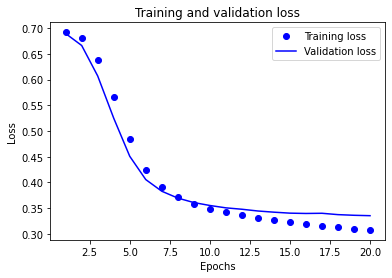

In [18]:
import matplotlib.pyplot as plt

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

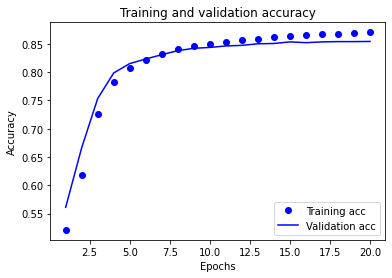

In [19]:
plt.clf()  
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

한국어 Word2Vec 임베딩 활용하여 성능 개선

In [20]:
embedding_layer = model.layers[0]
weights = embedding_layer.get_weights()[0]
print(weights.shape)

(10000, 16)


In [21]:
import os

word2vec_file_path = os.getenv('HOME')+'/aiffel/sentiment_classification/data/word2vec.txt'
f = open(word2vec_file_path, 'w')
f.write('{} {}\n'.format(vocab_size-4, word_vector_dim))  

vectors = model.get_weights()[0]
for i in range(8,vocab_size):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
f.close()

In [22]:
from gensim.models.keyedvectors import Word2VecKeyedVectors
word2vec_file_path = os.getenv('HOME')+'/data/word2vec_ko.model'
word_vectors = Word2VecKeyedVectors.load(word2vec_file_path)
vector = word_vectors.wv['끝']

In [23]:
vocab_size = 10000    
word_vector_dim = 300  
embedding_matrix = np.random.rand(vocab_size, word_vector_dim)

for i in range(8,vocab_size):
    if index_to_word[i] in vector:
        embedding_matrix[i] = vector[index_to_word[i]]

/tmp/ipykernel_47/405254129.py:7: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if index_to_word[i] in vector:


In [24]:
from tensorflow.keras.initializers import Constant

vocab_size = 10000   
word_vector_dim = 300  

model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(vocab_size, 
                                 word_vector_dim, 
                                 embeddings_initializer=Constant(embedding_matrix),  # 카피한 임베딩을 여기서 활용
                                 input_length=maxlen, 
                                 trainable=True))   # trainable을 True로 주면 Fine-tuning
model.add(tf.keras.layers.LSTM(128))
model.add(tf.keras.layers.Dense(64, activation='relu'))
model.add(tf.keras.layers.Dropout(0.3))
model.add(tf.keras.layers.Dense(1, activation='sigmoid')) 

model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 41, 300)           3000000   
_________________________________________________________________
lstm (LSTM)                  (None, 128)               219648    
_________________________________________________________________
dense_6 (Dense)              (None, 64)                8256      
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 65        
Total params: 3,227,969
Trainable params: 3,227,969
Non-trainable params: 0
_________________________________________________________________


In [25]:
# 학습의 진행
opt = RMSprop(learning_rate=0.0001)
model.compile(opt,
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=20  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=256,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/20
532/532 [==============================] - 6s 9ms/step - loss: 0.6179 - accuracy: 0.6503 - val_loss: 0.5175 - val_accuracy: 0.7439
Epoch 2/20
532/532 [==============================] - 4s 8ms/step - loss: 0.4938 - accuracy: 0.7632 - val_loss: 0.4375 - val_accuracy: 0.7999
Epoch 3/20
532/532 [==============================] - 4s 8ms/step - loss: 0.4332 - accuracy: 0.8009 - val_loss: 0.4021 - val_accuracy: 0.8160
Epoch 4/20
532/532 [==============================] - 4s 8ms/step - loss: 0.4012 - accuracy: 0.8196 - val_loss: 0.3741 - val_accuracy: 0.8326
Epoch 5/20
532/532 [==============================] - 4s 8ms/step - loss: 0.3819 - accuracy: 0.8304 - val_loss: 0.3703 - val_accuracy: 0.8343
Epoch 6/20
532/532 [==============================] - 4s 8ms/step - loss: 0.3666 - accuracy: 0.8386 - val_loss: 0.3562 - val_accuracy: 0.8421
Epoch 7/20
532/532 [==============================] - 4s 8ms/step - loss: 0.3557 - accuracy: 0.8441 - val_loss: 0.3564 - val_accuracy: 0.8422
Epoch 

In [26]:
# 테스트셋을 통한 모델 평가
results = model.evaluate(X_test,  y_test, verbose=2)

print(results)

1537/1537 - 3s - loss: 0.3311 - accuracy: 0.8562
[0.3311008810997009, 0.8561751246452332]


In [ ]:
#회고
#- 이번 프로젝트에서 어려웠던 점
#: 다양한 optmizer로 진행해보았는데, Adam과 RMSprop이 가장 좋은 결과를 낸다. 개인적으로는 RMSprop이 더 좋게 나왔다.
#- 프로젝트를 진행하면서 알아낸 점 혹은 아직 모호한 점
#: 왜 BOS값을 임의의 값으로 초기화하지 않으면 에러가 나는지 궁금하다. 필자는 for문을 활용해 1로 초기화를 진행했다.
#- 루브릭 평가 지표를 맞추기 위해 시도한 것들:
#: LSTM을 모델에 적용시키고 optimizer에 RMSprop을 적용해 기존 lms서 제공 받은 모델을 개선하였다.
#- 만약에 루브릭 평가 관련 지표를 달성 하지 못했을 때, 이유에 관한 추정:
#: 달성했다.
#- 자기 다짐:
#: 하면 된다.